In [1]:
from dobbel import dobbellogger
from help_functies import *
from calibrator import calibrate
dob = dobbellogger()

In [2]:
cali = calibrate(dob)
gyro_bias = cali['gyro bias']
acc_bias = cali['acc bias']
acc_std = cali['acc std']
gyro_std = cali['gyro std']

Leg de dobbelsteen met nummer  1  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  2  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  3  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf
{'gyro bias': array([-0.13909464,  0.45948489, -0.05529378]), 'acc bias': array([ 0.00057623,  0.0218244 , -0.04738061]), 'gyro std': array([0.08226149, 0.06118459, 0.07457718]), 'acc std': array([0.00163778, 0.00218435, 0.00228726])}


In [2]:
dob.connect()
dob.log(5, 100, 4, 250)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [3]:
# Deze code niet vaker dan 1 keer uitvoeren!
data = remove_nan(data)
data = rotate_data(data)

gyro_bias = [-0.10488443, 0.48133019, -0.05951701]
acc_bias = [0.00462698, 0.02152201, -0.04949736]

data['x_gyro'] = data['x_gyro'] - gyro_bias[0]
data['y_gyro'] = data['y_gyro'] - gyro_bias[1]
data['z_gyro'] = data['z_gyro'] - gyro_bias[2]
data['x_acc'] = data['x_acc'] - acc_bias[0]
data['y_acc'] = data['y_acc'] - acc_bias[1]
data['z_acc'] = data['z_acc'] - acc_bias[2]

In [3]:
data.head(1000)

NameError: name 'data' is not defined

In [5]:
y11 = np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
mb = np.array([1, 0, 0])

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) #- np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]

In [7]:
q11 = max_eigenvector

dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11 = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))

In [8]:
qtmin1tmin1 = np.reshape(q11, 4)
Ptmin1tmin1 = P11

v = np.array([0, 0, 0])
p = np.array([0, 0, 0])
q_list = [qtmin1tmin1]
p_list = [p]
v_list = [v]

std_gyro = [0.07516983, 0.06670297, 0.07491398]
Q = np.array([
    [std_gyro[0] ** 2, 0, 0],
    [0, std_gyro[1] ** 2, 0],
    [0, 0, std_gyro[2] ** 2]
])

std_acc = [0.00175222, 0.00147331, 0.00173477]
R = np.array([
    [std_acc[0] ** 2, 0, 0],
    [0, std_acc[1] ** 2, 0],
    [0, 0, std_acc[2] ** 2],
])

epsilon_list = []

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)
    
    Ftmin1 = right_quat_mul(expq_omega)
    Gtmin1 = - 0.5 * dt * np.matmul(left_quat_mul(qtmin1tmin1), dqde)
    
    Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)
    
    qttmin1 = quat_mul(qtmin1tmin1, expq_omega)
    
    #q0, q1, q2, q3 = quaternion_conjugate(qttmin1)
    q0, q1, q2, q3 = qttmin1
    # Zou kunnen dat hier de geconjugeerde genomen moet worden!!
    # H = np.array([
    #     [2 * q2, 2 * q3, 2 * q0, 2 * q1],
    #     [-2 * q1, -2 * q0, 2 * q3, 2 * q2],
    #     [4 * q0, 0, 0, 4 * q3]
    # ])
    H = np.array([
        [2 * q2, -2 * q3, 2 * q0, -2 * q1],
        [-2 * q1, -2 * q0, -2 * q3, -2 * q2],
        [-4 * q0, 0, 0, -4 * q3]
    ])
    S = np.matmul(np.matmul(H, Pttmin1), H.T) + R
    K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))
    
    yat = np.array([data['x_acc'][i], data['y_acc'][i], data['z_acc'][i]]) # - acc_bias
    #yattmin1 = rotate_vector(gn, qttmin1) #quaternion_conjugate(qttmin1)) # Zou kunnen dat hier een min voor moet!!! en geconjugeerde
    yattmin1 = rotate_vector(gn, quaternion_conjugate(qttmin1))
    #yattmin1 = np.array([-2*q1*q3+2*q0*q2, -2*q2*q3-2*q0*q1, -2*q0**2-2*q3**2+1])
    epsilon = yat - yattmin1
    print(data['timestamp'][i], yat, yattmin1)

    q_tt_measure = np.reshape(qttmin1, (4, 1)) + np.matmul(K, np.reshape(epsilon, (3, 1)))
    P_tt_measure = Pttmin1 - np.matmul(np.matmul(K, S), K.T)
    
    qtt = q_tt_measure / ((np.linalg.norm(q_tt_measure)))
    #J = np.matmul(q_tt_measure, q_tt_measure.T) / (np.linalg.norm(q_tt_measure) ** 3)
    Ptt = P_tt_measure #np.matmul(np.matmul(J, P_tt_measure), J.T) 
    
    Ptmin1tmin1 = Ptt
    qtmin1tmin1 = np.reshape(qtt, 4)
    
    q_list.append(qtmin1tmin1)
    epsilon_list.append(epsilon)
    

10.0 [ 0.0077258  -1.03397318  0.01756138] [ 0.0081552  -0.99977092  0.01978913]
20.0 [ 0.00886884 -1.03397318  0.01770162] [ 0.00898012 -0.99969577  0.02297209]
30.0 [ 0.00674105 -1.0334849   0.01644979] [ 0.00913455 -0.99960993  0.02639217]
41.0 [ 0.00592282 -1.03446146  0.01939994] [ 0.01706639 -0.99923004  0.03532808]
50.0 [ 0.00913539 -1.03580424  0.0177604 ] [ 0.02071264 -0.99851637  0.05035921]
51.0 [ 0.00931884 -1.03563334  0.01768904] [ 0.02403128 -0.99725941  0.06997263]
60.0 [ 0.01096983 -1.03409525  0.01704684] [ 0.02719727 -0.99556315  0.09007951]
70.0 [ 0.008444   -1.03324076  0.0186142 ] [ 0.03047167 -0.99254231  0.11803066]
80.0 [ 0.00770312 -1.03385111  0.01817131] [ 0.03441729 -0.98692311  0.15747452]
91.0 [ 0.00876469 -1.03397318  0.01918804] [ 0.03865409 -0.97641836  0.21239834]
101.0 [ 0.00963241 -1.03397318  0.01753457] [ 0.04284677 -0.95611704  0.28983506]
111.0 [ 0.01012995 -1.0367808   0.01401059] [ 0.04652461 -0.91907109  0.3913359 ]
121.0 [ 0.00842184 -1.0343

In [9]:
euler_x = []
euler_y = []
euler_z = []

for q, timestamp in zip(q_list, data['timestamp']):
    euler = quat_to_euler(q) * 180 / np.pi
    euler_x.append(euler[0])
    euler_y.append(euler[1])
    euler_z.append(euler[2])

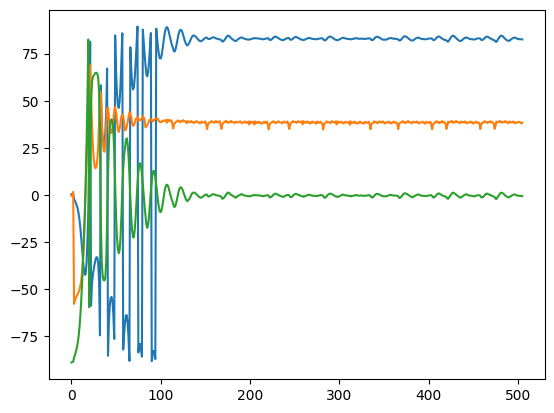

In [10]:
import matplotlib.pyplot as plt

plt.plot(euler_x)
plt.plot(euler_y)
plt.plot(euler_z)

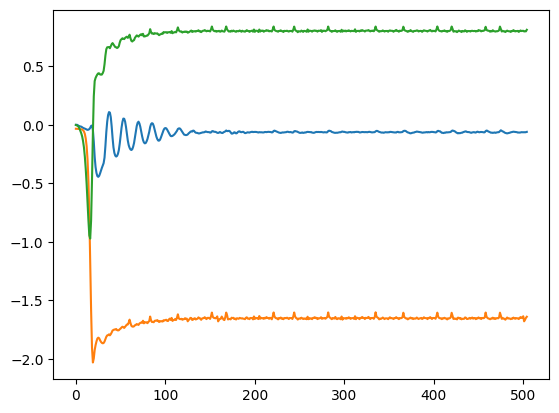

In [11]:
epsilons = np.concatenate(epsilon_list)
epsilons = np.reshape(epsilons, (int(len(epsilons) / 3), 3))

plt.plot(epsilons[:, 0])
plt.plot(epsilons[:, 1])
plt.plot(epsilons[:, 2])